# Tangle demo on a mixture of gaussians

Simple script for exemplary use of the tangle framework.
The execution is divided in the following steps

    1. Load datasets
    2. Find the cuts and compute the costs
    3. For each cut compute the tangles by expanding on the
          previous ones if it is consistent. If its not possible stop
    4. Postprocess in soft and hard clustering

In [35]:
from functools import partial
from pathlib import Path

import sklearn
import numpy as np

from tangles import cost_functions, data_types, plotting, loading, cut_finding, utils, tree_tangles

### Define yout parameters

In [2]:
seed = 42
agreement = 20

### Load your data

In [6]:
xs, ys = loading.load_GMM(blob_sizes=[200, 200], blob_centers=[[-2, -2], [2, 2]], blob_variances=[[1, 1], [1, 1]], seed=42)

data = data_types.Data(xs=xs, ys=ys)

Now we preprocess the data by calculating a set of bipartition.

In [8]:
print("Generating set of bipartitions")
values, names = cut_finding.a_slice(xs=data.xs, a=agreement)
bipartitions = data_types.Cuts(values=values, names=names)
print("Found {} unique bipartitions".format(len(bipartitions.values)))

Generating set of bipartitions
Found 42 unique bipartitions


Given a cost function we calculate the cost of all bipartitions and sort them accordingly.

In [9]:
print("Calculating costs of bipartitions")
cost_fun = cost_functions.gauss_kernel_distance
bipartitions = utils.compute_cost_and_order_cuts(bipartitions, partial(cost_fun, data.xs, None))

Calculating costs of bipartitions
Computing costs of cuts...


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1382.53it/s]


### Now we can build the tangle search tree.

In [13]:
print("Building the tangle search tree", flush=True)
tangles_tree = tree_tangles.tangle_computation(cuts=bipartitions,
                                  agreement=agreement,
                                  verbose=0  # print everything
                                  )

Building the tangle search tree


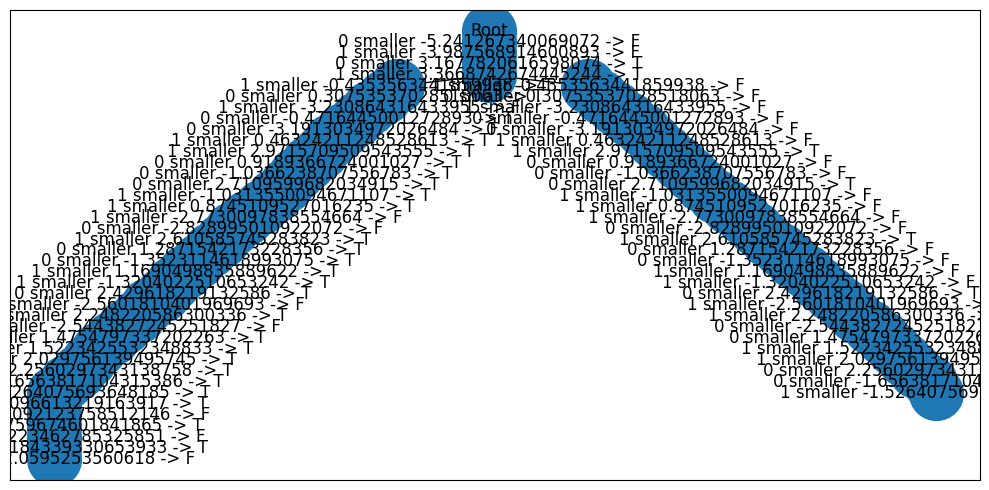

In [14]:
### uncomment if you have graphvis installed on your system
# tangles_tree.plot_tree()

We want to posrprocess the tree by contracting paths.

In [21]:
# postprocess tree
print("Postprocessing the tree.", flush=True)
# contract to binary tree
print("Contracting to binary tree", flush=True)
contracted_tree = tree_tangles.ContractedTangleTree(tangles_tree)

Postprocessing the tree.
Contracting to binary tree


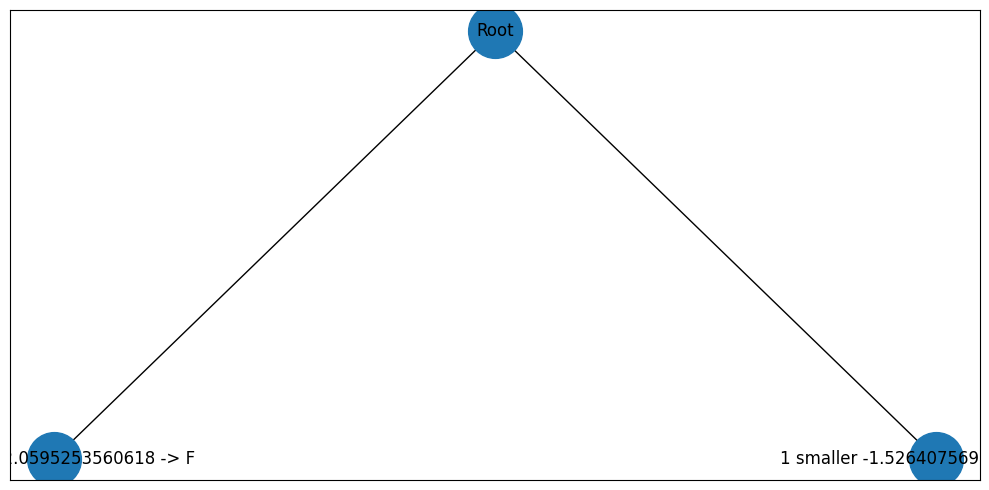

In [22]:
### uncomment if you have graphvis installed on your system
# contracted_tree.plot_tree()

In [23]:
# prune short paths
print("Pruning short paths (length at most 5)", flush=True)
contracted_tree.prune(1)

Pruning short paths (length at most 5)
	2 clusters after cutting out short paths.


In [24]:
### uncomment if you have graphvis installed on your system
# contracted_tree.plot_tree()

In [25]:
# calculate
print("Calculating set of characterizing bipartitions", flush=True)
contracted_tree.calculate_setP()

Calculating set of characterizing bipartitions


In [30]:
# compute soft predictions
# assign weight/ importance to bipartitions
weight = np.exp(-utils.normalize(bipartitions.costs))

# propagate down the tree
print("Calculating soft predictions", flush=True)
tree_tangles.compute_soft_predictions_children(node=contracted_tree.root,
                                  cuts=bipartitions,
                                  weight=weight,
                                  verbose=3)

contracted_tree.processed_soft_prediction = True

Calculating soft predictions


In [31]:
print("Calculating hard predictions", flush=True)
ys_predicted, _ = utils.compute_hard_predictions(contracted_tree, cuts=bipartitions)

Calculating hard predictions


In [32]:
# evaluate hard predictions
if data.ys is not None:
    ARS = sklearn.metrics.adjusted_rand_score(data.ys, ys_predicted)
    NMI = sklearn.metrics.normalized_mutual_info_score(data.ys, ys_predicted)

    print('Adjusted Rand Score: {}'.format(np.round(ARS, 4)), flush=True)
    print('Normalized Mutual Information: {}'.format(np.round(NMI, 4)), flush=True)

Adjusted Rand Score: 0.99
Normalized Mutual Information: 0.9773


In the following we visualize the ouput.

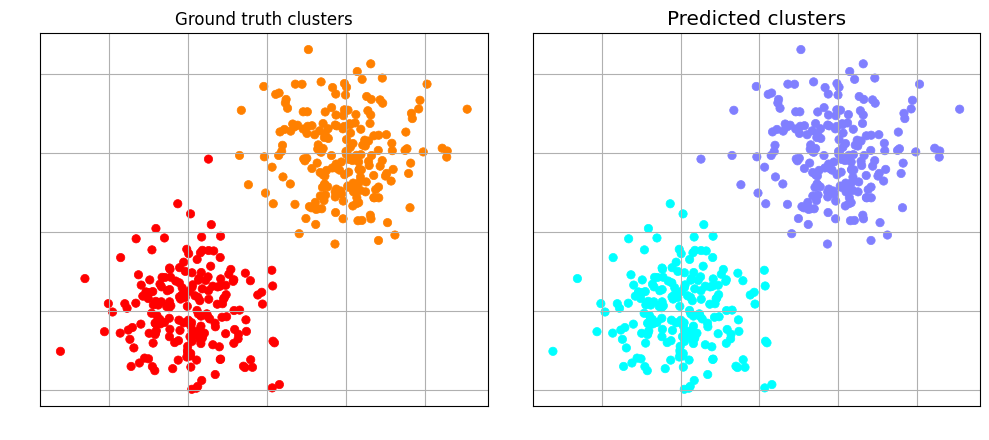

In [33]:
# plot hard clustering
plotting.plot_hard_predictions(data=data, ys_predicted=ys_predicted, path=None)

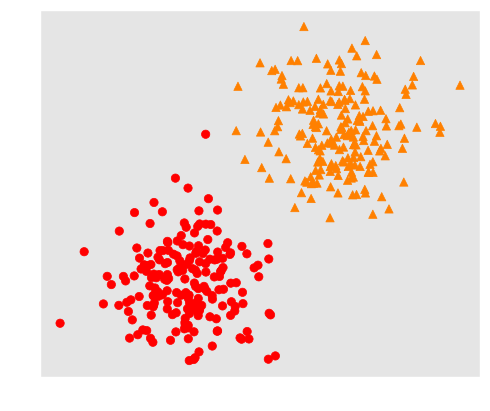

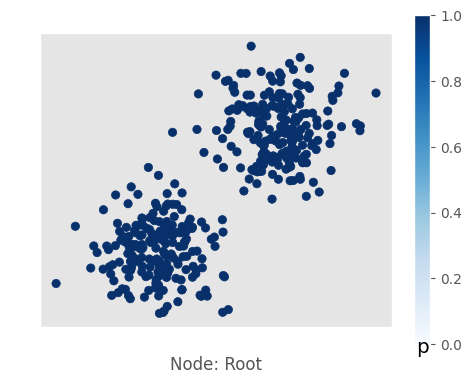

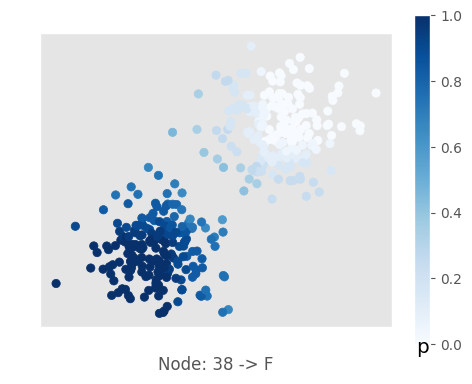

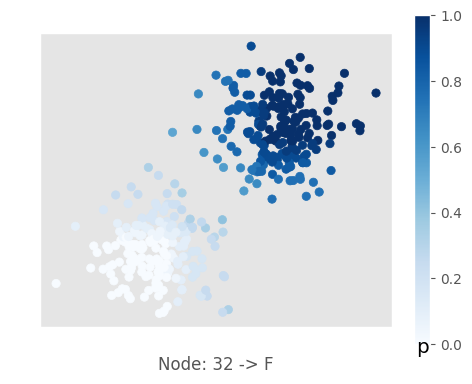

In [34]:
# plot soft predictions
plotting.plot_soft_predictions(data=data,
                                   contracted_tree=contracted_tree,
                                   eq_cuts=bipartitions.equations,
                                   path=None)

We can plot the cheapest cuts.

In [ ]:
plotting.plot_cuts(data=data, cuts=bipartitions, nb_cuts_to_plot=10, path=None)